# Assignment 3 - Machine Learning Fashionista
## Oscar Engelbrektson
## CS156, Prof. Albrecht, Fall 2019

Using a dataset with pictures of Men's clothing and Women's clothing from Image Net (used in class 4.1), we examine three approaches to building a  binary classifier to discern men's shirts from women's shirts. The three approaches are Logistic Regression, dimensionality reduction using PCA followed by Logistic regression, and dimensionality reduction using LDA followed by Logistic regression. The aim is to determine which classifier is best suited to the task.

As there is no reason to prefer one type of error to another (it is no better to get a women's shirt right than it is a man's, and vice versa), the metric by which we evaluate these different approaches will be test set accuracy–the proportion of test set pictures correctly classified by the model.

Before any model fitting is performed, the pictures are resized programmatically so that they all have the same dimensionality. The same train-test split is used for all models.

In [2]:
from PIL import Image
import PIL.ImageOps

from collections import defaultdict
import glob
from random import shuffle, seed
import numpy as np
import pylab as pl
import pandas as pd
import re

# Import image datasets

In [3]:
#Code adapted from https://github.com/joelgrus/shirts/blob/master/visuals.py

STANDARD_SIZE = (138,138)
HALF_SIZE = (STANDARD_SIZE[0]/2,STANDARD_SIZE[1]/2)

def img_to_array(filename):
    """
    takes a filename and turns it into a numpy array of RGB pixels
    """
    img = Image.open(filename)
    img = img.resize(STANDARD_SIZE)
    img = list(img.getdata())
    #img = map(list, img)s
    img = np.array(img)
    s = img.shape[0] * img.shape[1]
    img_wide = img.reshape(1, s)
    return img_wide[0]

# my files are set up like "images/girls/gapkids/image1.jpg" and "images/boys/oldnavy/image1.jpg"
woman_files = glob.glob("/Users/oscarengelbrektson/Downloads/Woman's Clothing - n04596852/*")
man_files = glob.glob("/Users/oscarengelbrektson/Downloads/Man's Clothing - n03746330/*")

process_file = img_to_array

#Take the 100 first jerseys and 100 first shirts and make a dataset
raw_data = [(process_file(woman_files[i]), 'woman')for i in range(10)] + \
           [(process_file(man_files[i]), 'man')for i in range(10)]

In [4]:
#Checking the shape the array representation of an observation
raw_data[0][0].shape

(57132,)

In [5]:
#Looking at some of the pictures in the respective datasets
for i in range(10):
    Image.open(woman_files[i]).show()
    Image.open(man_files[i]).show()

Do note that the quality of both mens and womans data set are of poor quality. The picture vary greatly accross most high-level dimensions I can think of: the position of the shirts, the lighting, whether it is worn by a paerson or not, the angle, and so on. This does not bode well for classification performance, as unnestling patterns in this data seems much more challenging than would have been the case had the picture format been more standardized.

# Define training and test sets

In [150]:
# randomly order the data
import random
seed(0)
shuffle(raw_data)

# pull out the features and the labels
data = np.array([cd for (cd,_y) in raw_data])
labels = np.array([_y for (cd,_y) in raw_data])

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data,labels,test_size=0.2,random_state=25)

In [115]:
#shape of train and test objects
print(X_train.shape)
print(X_test.shape)

(1600, 57132)
(400, 57132)


In [116]:
# shape of new y objects
print(y_train.shape)
print(y_test.shape)

(1600,)
(400,)


# 1. Simple linear classifier using the original pixel data

In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

### Using cross validation to select hyperparameter C

In [118]:
#List of different values to try for the regularization parameter C
c_values = [0.001,0.01,0.1,1,10,100]
accuracy_list = []

#Calculating validation set accuracy for each value of c
for k in c_values:
    model = LogisticRegression(C=k, solver="lbfgs", max_iter=5000)
    cv_results = cross_validate(model, X_train, y_train,
                            scoring=['accuracy'], cv=5)
    
    #Store average accuracy accross the five splits
    accuracy_list.append(np.mean(cv_results['test_accuracy']))

### Visualizing the results

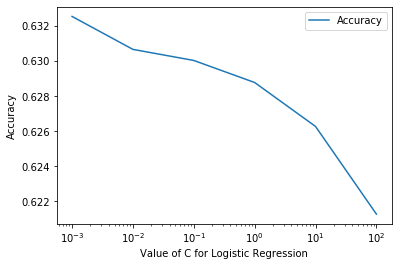

In [119]:
import matplotlib.pyplot as plt
%matplotlib inline

#Using a loged x-axis as the c values differ by an order of magnitude each
plt.semilogx(c_values, accuracy_list, label="Accuracy")
plt.legend(loc=0)
plt.xlabel('Value of C for Logistic Regression')
plt.ylabel('Accuracy')
plt.show()

### Evaluating performance on the test set

In [151]:
#Selecting c=0.01 as it has the highest average accuracy,
model = LogisticRegression(C=0.01, solver="lbfgs", max_iter=5000)
model.fit(X_train,y_train)

#Making prediction on the seen training data 
y_pred=model.predict(X_train)
print("train set accuracy:", accuracy_score(y_train,y_pred))

#Making prediction on the unseen test data 
y_pred=model.predict(X_test)
print("test set accuracy:", accuracy_score(y_test,y_pred))

train set accuracy: 1.0
test set accuracy: 0.6375


# 2. Pre-processing data using PCA, then applying the same classifier

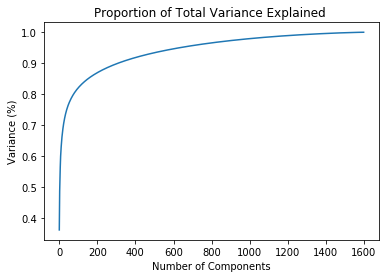

In [121]:
from sklearn.decomposition import PCA
X_train,X_test,y_train,y_test = train_test_split(data,labels,test_size=0.2,random_state=25)

pca = PCA(random_state=0)
X = pca.fit_transform(X_train)
y = y_train

#Getting a sense for the by plotting the Cumulative Summation of the Explained Variance
#This informs the values tested in CV
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Proportion of Total Variance Explained ')
plt.show()

### Using cross validation to select the number of principal components to use

In [122]:
n_components = [x for x in range(1, 200, 10)] 
accuracy_list = []

for k in n_components:
    X_train,X_test,y_train,y_test = train_test_split(data,labels,test_size=0.2,random_state=25)
    pca = PCA(n_components=k, random_state=0)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    model = LogisticRegression(C=10, solver="lbfgs", max_iter=20000)
    cv_results = cross_validate(model, X_train, y_train,
                            scoring=['accuracy'], cv=5)
    
    #Store average accuracy accross the five splits
    accuracy_list.append(np.mean(cv_results['test_accuracy']))

### Visualizing the CV results

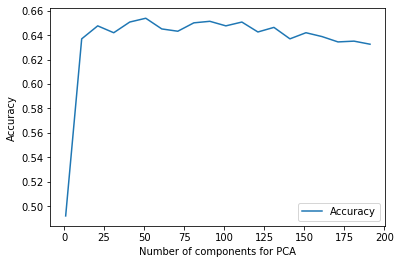

In [155]:
plt.plot(n_components, accuracy_list, label="Accuracy")
plt.legend(loc=4)
plt.xlabel('Number of components for PCA')
plt.ylabel('Accuracy')
plt.show()

### Evaluating performance on the test set

In [149]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=25)

#Selecting n_components=15 as it has the highest average accuracy
pca = PCA(n_components=15, random_state=0)
X_train = pca.fit_transform(X_train)

#Transforming X_test using the PCA trained on X_train
X_test = pca.transform(X_test)

#Fitting the same Logistic Regression model as before but now on the transformed data
#The results are not affected by the regularization parameter C -> no CV required
model = LogisticRegression(C=10, solver="lbfgs", max_iter=5000)
model.fit(X_train,y_train)

#Making prediction on the seen training data 
y_pred=model.predict(X_train)
print("train set accuracy:", accuracy_score(y_train,y_pred))

#Making prediction on the unseen test data 
y_pred=model.predict(X_test)
print("test set accuracy:", accuracy_score(y_test,y_pred))

train set accuracy: 0.6734375
test set accuracy: 0.625


# 3. Pre-processing data using LDA, then applying the same classifier

In [125]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [153]:
#The upper bound on the number of components that can be used in LDA is given by n_classes-1
#As we only have two classes, we must choose n_components=1 (no CV necessary)

#Splitting the data into the same training and test set used previously
X_train,X_test,y_train,y_test = train_test_split(data,labels,test_size=0.2,random_state=25)

#Performing LDA using the test set
lda = LinearDiscriminantAnalysis(n_components = 1)
X_train = lda.fit_transform(X_train, y_train)

#transforming X_test based on lda from training set
X_test = lda.transform(X_test)

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [154]:
#Running the logistic regressionmodel on the transformed data
#The results are not affected by the regularization parameter C -> no CV required
model = LogisticRegression(C=0.01, solver="lbfgs", max_iter=5000)
model.fit(X_train,y_train)

#Making prediction on the seen training data 
y_pred=model.predict(X_train)
print("train set accuracy:", accuracy_score(y_train,y_pred))

#Making prediction on the unseen test data 
y_pred=model.predict(X_test)
print("test set accuracy:", accuracy_score(y_test,y_pred))

train set accuracy: 0.931875
test set accuracy: 0.5775


# Describing and interpreting the results from the 3 approaches and making a recommendation

The first approach, fitting an ordinary Logistic Regression to the data yielded a training accuracy of 1 and test accuracy of 0.64–the best of all approaches examined. The logistic regression is thus able to perfectly separae the two classes in training, but this classification accuracy does not generalize without significant deterioration to unseen data. Note also that the training time of this model was considerable, particularly the CV procedure for selecting the regularixation parameter C. 

The second approach yielded a training accuracy of 0.67 and test accuracy of 0.62, a rather small discrepancy indicating that the performance generalizes well to unseen data (low variance). That said, the accuracy is still lower than approach 1. However, there is in value in dimensionality reduction above and beyond its effects on accuracy. It greatly decreases the runtime for our classication algorithm and, should we decide to use a different classifier more vulnerable to the curse of dimensionality, it may drastically improve results compared to the original method.

LDA should, in theory, give the best classification accuracy out of the three approaches, as it is supervised and performs dimensionality reduction with the explicit aim of increasing class separability. In this case, however, it is the method that yields the worst performance of all. By comparing the high train set accuracy, 0.93 to the low test set accuracy 0.57 we see that the projections that yield the best class separability on the train set do not generalize well to out-of-sample data. This should perhaps not be surprising given the low quality of the data set.

In the end then, even though the ordinary logistic regression edged out PCA in terms of test-set accuracy, I would recommend using the second approach–PCA followed by Logistic Regression–because of the drastic runtime advantages it offers (it takes me forever to run the first approach on my computer). How to reason about trade-offs between time and accuracy, however, is hugely context dependent. If in a situation where accuracy is clearly more important, e.g. an offline analysis setting, it may still be better to opt for the first approach (in such a situation, however, I would also recommend exploring other models than just logistic regression in the quest for higher accuracy).